In [26]:
from pathlib import Path
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
from utils.data_extractors import *
from utils.visualizations import *
import seaborn as sns
from scipy.stats import sem
from scipy.signal import convolve2d

In [27]:
# def plot_episode_len(params: np.array, data: np.array, row=None, col=None, plot=None, xlabel='', ylabel='', rowdict={}, coldict={}):
#     """
#     General-use function for plotting a episode length

#     args: 
#         params : np.array shape (num_runs, num_params) with parameters for each run
#         data : np.array shape (num_runs, num_timesteps) with data
#         row : index of parameters, this function will generate a subplot for each unique setting
#         col : index of parameters, this function Will generate a subplot for each unique setting
#         plot : index of parameters, for which a new line will be added to a subplot for each unique value
        
#     """

#     nrows = np.unique(params[:, row]).shape[0]
#     ncols = np.unique(params[:, col]).shape[0]

#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, squeeze=False, figsize=(10,10))

#     row_idx = 0
#     for row_param in np.unique(params[:, row]):
#         col_idx = 0
#         for col_param in np.unique(params[:, col]):
#             for plot_param in np.unique(params[:, plot]):
#                 inds = np.where(
#                     (params[:, row]==row_param) & 
#                     (params[:, col]==col_param) & 
#                     (params[:, plot]==plot_param))
                
#                 ax = axs[row_idx, col_idx]
#                 for run_data in data[inds]:
#                     if len(run_data) > 1:
#                         ax.plot(np.arange(len(run_data)),  run_data)
#                     else:
#                         ax.scatter([0], run_data)
                   

#                 ax.set_title('%s, %s' % (rowdict.get(row_param, row_param), coldict.get(col_param, col_param)))
#                 ax.set_xlabel(xlabel)
#                 ax.set_ylabel(ylabel)
#                 ax.set_yscale('log')
                
#                 ax.spines['right'].set_visible(False)
#                 ax.spines['top'].set_visible(False)
                
#             col_idx += 1
#         row_idx += 1

#     fig.tight_layout()


In [28]:
def extract_num_episodes(root: str, param_names: list, filters=None):
    """
    Extract number of episodes

    args
        root : directory where results are stored
        param_names : a list of parameters to extract for each run, stored in params.json 
        env: which environment to extract this for
    """

    all_episodes = []
    all_params = []

    for dir in tqdm(root.iterdir()):    
        params_file = dir/'params.json'               
        params = json.load(open(params_file))
        params_run  = [] # relevant parameters for a single run

        filter = False
        for p in param_names:
            params_run.append(params.get(p, None))
            value = params.get(p, None)
            
            if filters is not None:
                allowed_values = filters.get(p)
                if allowed_values is not None and value not in allowed_values:
                    filter = True

        if filter == False:
            all_params.append(params_run)
            episode_len= np.load(dir/"episode_lengths.npy")
            all_episodes.append( np.mean(episode_len[-10:]) )
    
    return np.array(all_params),  np.array( all_episodes)

In [29]:
root = Path('results_new_sweep')
params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'])

10800it [00:52, 205.34it/s]


In [30]:
df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']


df = df.drop(['Seed'],axis=1)

In [31]:
df_  = df.groupby(['Model', 'Env', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size']).mean().reset_index()
#df_['Learning'] = df_['Learning Freq.'] + ', ' + df_['Target Update Freq.'] 
df_['Algorithm'] = df_['Model'] + ', ' + df_['L'] 
df_ = df_.drop(['Model', 'L' ], axis=1)

In [80]:
df = df.replace('FFN, 10', 'FFN')

In [33]:
df_.to_csv("param_sweep.csv")

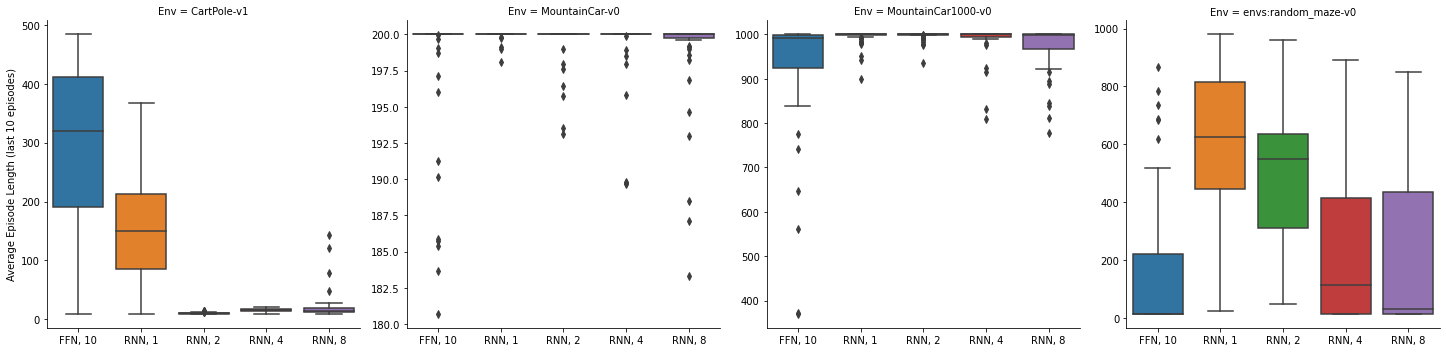

In [36]:
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df_, kind='box', sharey=False)
g.set_axis_labels("", "Average Episode Length (last 10 episodes)")
plt.savefig('figures/sensitivity_box_last_10.pdf', bbox_inches='tight')

In [57]:
#best hypedrparameters:
inds = []
for env in df_['Env'].unique():
    for alg in df_['Algorithm'].unique():
        df_env_alg = df_.loc[(df_['Env'] == env) & (df_['Algorithm'] ==alg)].nlargest(1,"Num Episodes")
        df_env_alg = df_env_alg.set_index(['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'])
        inds += df_env_alg.index.tolist()
        print(df_env_alg.index.tolist())

[('FFN', 'CartPole-v1', '1', '1', '5e-05', '10000')]
[('RNN, 1', 'CartPole-v1', '1', '1', '0.005', '100000')]
[('RNN, 2', 'CartPole-v1', '1', '1000', '0.005', '100000')]
[('RNN, 4', 'CartPole-v1', '100', '100', '5e-05', '10000')]
[('RNN, 8', 'CartPole-v1', '100', '1000', '0.005', '10000')]
[('FFN', 'MountainCar-v0', '1', '1', '0.0005', '10000')]
[('RNN, 1', 'MountainCar-v0', '1', '1', '0.0005', '10000')]
[('RNN, 2', 'MountainCar-v0', '1', '1', '0.0005', '10000')]
[('RNN, 4', 'MountainCar-v0', '1', '1', '0.0005', '10000')]
[('RNN, 8', 'MountainCar-v0', '1', '1', '0.0005', '10000')]
[('FFN', 'MountainCar1000-v0', '1', '1', '0.0005', '100000')]
[('RNN, 1', 'MountainCar1000-v0', '1', '1', '5e-05', '10000')]
[('RNN, 2', 'MountainCar1000-v0', '1', '1', '0.0005', '10000')]
[('RNN, 4', 'MountainCar1000-v0', '1', '1', '0.0005', '10000')]
[('RNN, 8', 'MountainCar1000-v0', '1', '1', '0.0005', '10000')]
[('FFN', 'envs:random_maze-v0', '100', '1000', '5e-05', '100000')]
[('RNN, 1', 'envs:random_maz

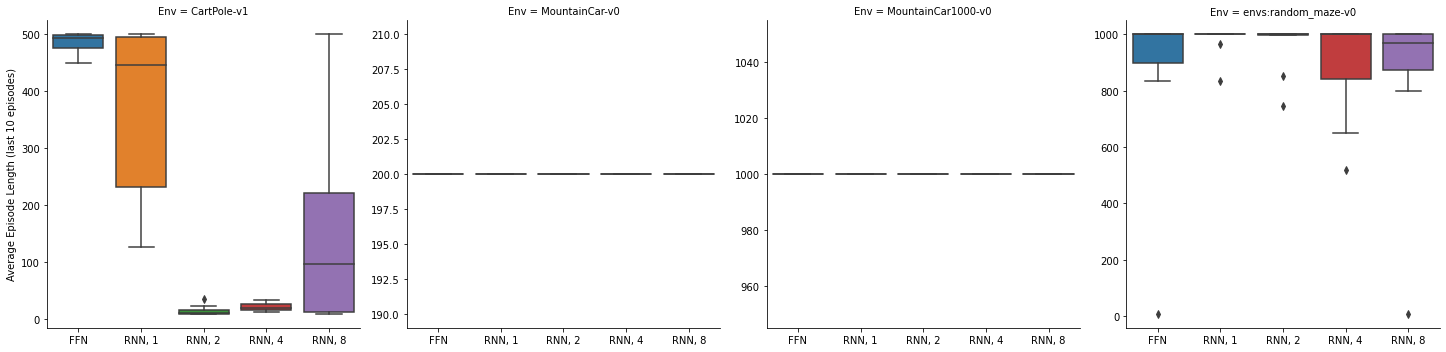

In [88]:

# df['Algorithm'] = df['Model'] + ', ' + df['L'] 
# df = df.drop(['Model', 'L' ], axis=1)
df__ = df.set_index(['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'])
df__ = df__.loc[inds]
df__ = df__.reset_index()
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df__, kind='box', sharey=False)
g.set_axis_labels("", "Average Episode Length (last 10 episodes)")